# Алгоритмический поиск локтевой точки для определения приемлемых значений метрик машинного обучения

Часто бывает так, что изменяя какие-нибудь характеристики модели мы постепенно повышаем скор, но сначала это повышения является значительным, а начиная с какого-то места, формальный рост продолжается, но уже не приносит значмых улучшений. Точка в который быстрый рост замедляется и становится уже несущественным называется локтевой точкой.

Известно, что даже если функция задана аналитически, получить формулу для локтевой точки невозможно. Поэтому аналитики, изучая такие ситуации, действуют на глаз: просто глядя на график функции скора. Однако, как быть, если результат требуется получать очень часто и очень быстро? В этой работе мы предлагаем алгоритм, который справляется с этой задачей.

Подробный разбор алгоритма и идей, которые в него заложены см. в [полной статье в формате pdf](paper.pdf).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import sklearn.linear_model as skl

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

## Определение функции fold_point

Наш алгоритм мы зашиваем в функцию, которая принимает на вход два массива (причем именно первый массив считается горизонтальной переменной, и именно второй массив считается вертикальной переменной), а возвращает номер локтевой точки.

In [2]:
def fold_point(A, B):
    
    # Сразу считаем знаменатель коэффициента детерминации
    S_line = ((B - B.mean())**2).sum()
    
    # заводим список для коэффициентов детерминации, которые будут получаться в цикле
    R2_list = []
    
    # Устанавливаем влеичину сдвига
    shift = 3
    
    # Проводим в цикле разбиения массивов внутренней точкой на левую и правую части
    for i in np.arange(shift, len(A) - shift):
        
        # Данные для левой модели
        X_left = A[:i].reshape(-1, 1)
        y_left = B[:i]
        
        # Учим левую модель
        model_left = skl.LinearRegression()
        model_left.fit(X_left, y_left)

        # Предсказания левой модели
        y_pred_left = model_left.predict(X_left)
        
        # Считаем левый фрагмент числителя коэффициента детеминации
        S_star_left = ((y_pred_left - y_left)**2).sum()
        
        # То же самое для правого участка
        X_right = A[i:].reshape(-1, 1)
        y_right = B[i:]

        model_right = skl.LinearRegression()
        model_right.fit(X_right, y_right)

        y_pred_right = model_right.predict(X_right)

        S_star_right = ((y_pred_right - y_right)**2).sum()
        
        # Общий числитель коэффициента детерминации
        S_star = S_star_left + S_star_right
        
        # Коэффициент детерминации, посчитанный по поределению
        R2 = 1 - S_star/S_line
        
        # Аппендим в список скоров
        R2_list.append(R2)
        
    # Формируем черновой индекс локтевой точки    
    fold_inedex_draft = np.array(R2_list).argmax() + shift
    
    # Проверяем условие возрастания и формируем окончательный индекс
    if B[fold_inedex_draft] >= B[fold_inedex_draft - 1]:
    
        fold_index = fold_inedex_draft
        
    else:
        
        fold_index = fold_inedex_draft - 1
    
    return fold_index

## Пример на синтетических данных

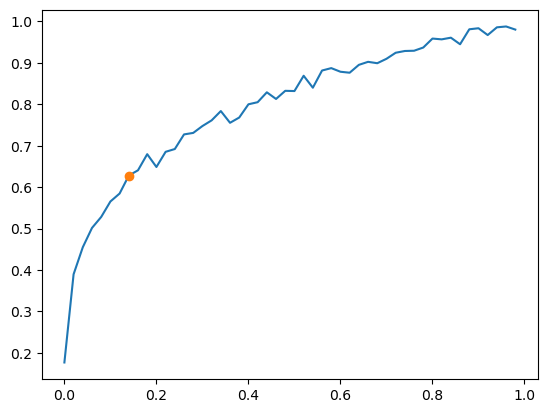

In [20]:
# Готовим синтетику
arr_1 = np.arange(0.001, 1, 0.02)
arr_2 = arr_1**(1/4) + np.random.normal(loc=0.0, scale=0.01, size=len(arr_1))

# Применяем наш алгоритм
fold_point(arr_1, arr_2)

# Рисуем картинку
plt.plot(arr_1, arr_2)
plt.plot(arr_1[fold_point(arr_1, arr_2)], arr_2[fold_point(arr_1, arr_2)], 'o')